In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline

In [5]:
def getData(path):
    df = pd.read_csv(path, sep=',', header=0, index_col=0)
    return df
bmr = getData('../../data/hosts/bodymass.csv')
hgd = getData('../../data/hosts/hostdistance.csv')
ar = getData('../../beast/main/discreteTraits/results/discreteTraits_2016-10-25_actualRates.csv')

names = pickle.load(open('../../data/hosts/common_names.p', 'rb'))

names = { v:k for k,v in names.items()}
names['Chimp_pts'] = 'Pan_troglodytes_schweinfurthii'
ar.rename(index=names, columns=names, inplace=True)

mean = ar.stack().mean()
stddev = ar.stack().std()

norm = lambda x: (float(x) - float(mean)) / float(stddev)
ar = ar.applymap(norm)



In [6]:
ar_vals = []
bmr_vals = []
hgd_vals = []

hosts = ar.columns.values

for from_host in hosts:
    for to_host in hosts:
        if from_host == to_host:
            continue
        else:
            ar_vals.append(ar.at[from_host, to_host])
            bmr_vals.append(bmr.at[from_host, to_host])
            hgd_vals.append(hgd.at[from_host, to_host])
assert len(ar_vals)==len(bmr_vals)
assert len(hgd_vals)==len(bmr_vals)

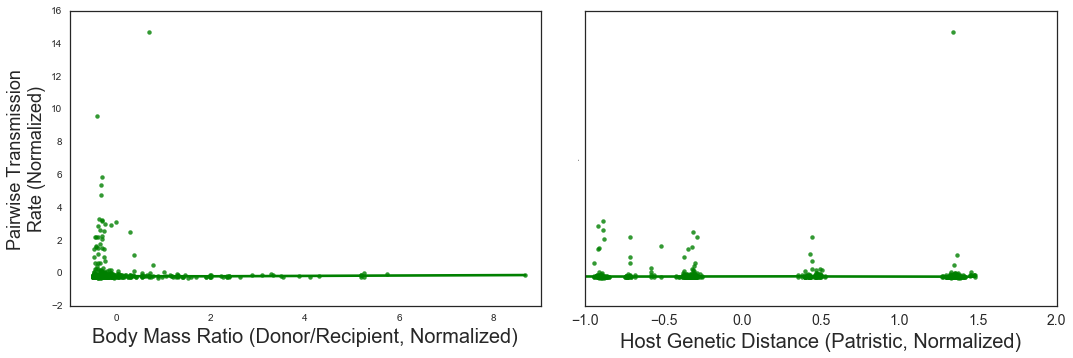

In [18]:
fig, (bmr_ax, hgd_ax) = plt.subplots(figsize=(15,5),nrows=1,ncols=2,sharey=True, facecolor='w')

bmr_line = sns.regplot(pd.Series(bmr_vals), pd.Series(ar_vals), color='g', lowess=True, ax=bmr_ax)
hgd_line = sns.regplot(pd.Series(hgd_vals), pd.Series(ar_vals), color='g', ax=hgd_ax, lowess=True)

hgd_ax.set_xlabel('Host Genetic Distance (Patristic, Normalized)', size=20)
bmr_ax.set_ylabel('Pairwise Transmission\nRate (Normalized)', size=18)
bmr_ax.set_xlabel('Body Mass Ratio (Donor/Recipient, Normalized)', size=20)
hgd_ax.set_ylabel(None, size=0)

sns.set_style('white')
bmr_ax.set_xlim(-1, 9)
hgd_ax.set_xlim(-1, 2)
plt.tight_layout()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Figure 4: Cross-species transmission is driven by exposure and constrained by host genetic distance.  
LOWESS fit illustrating the relationship between the asymmetric transmission rates between each pair of hosts vs. **A** the ratio of body masses (donor / recipient host) and **B** the genetic distance between the hosts.

In [17]:
import scipy

bmr_reg_x = bmr_line.get_lines()[0].get_xdata()
bmr_reg_y = bmr_line.get_lines()[0].get_ydata()
hgd_reg_x = hgd_line.get_lines()[0].get_xdata()
hgd_reg_y = hgd_line.get_lines()[0].get_ydata()

bmr_slope, bmr_intercept, bmr_r_value, bmr_p_value, bmr_std_err = scipy.stats.linregress(bmr_reg_x, bmr_reg_y)
hgd_slope, hgd_intercept, hgd_r_value, hgd_p_value, hgd_std_err = scipy.stats.linregress(hgd_reg_x, hgd_reg_y)

print 'BMR: ', bmr_slope, bmr_intercept, bmr_r_value**2, bmr_p_value, bmr_std_err
print 'HGD: ', hgd_slope, hgd_intercept, hgd_r_value**2, hgd_p_value, hgd_std_err

BMR:  0.0127672161528 -0.215819066536 0.448740008205 3.78123032172e-73 0.000603386664838
HGD:  -0.00501483256656 -0.212205618309 0.645780591115 4.74226337971e-126 0.000158368489932
